In [18]:
# - Data processing
import numpy as np

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

# - Import modules
from rockpool.devices.xylo.imu.preprocessing import (
    Quantizer,
    RotationRemoval,
    FilterBank,
    FullWaveRectifier,
)
from rockpool.nn.combinators import Sequential


## Get the data sample

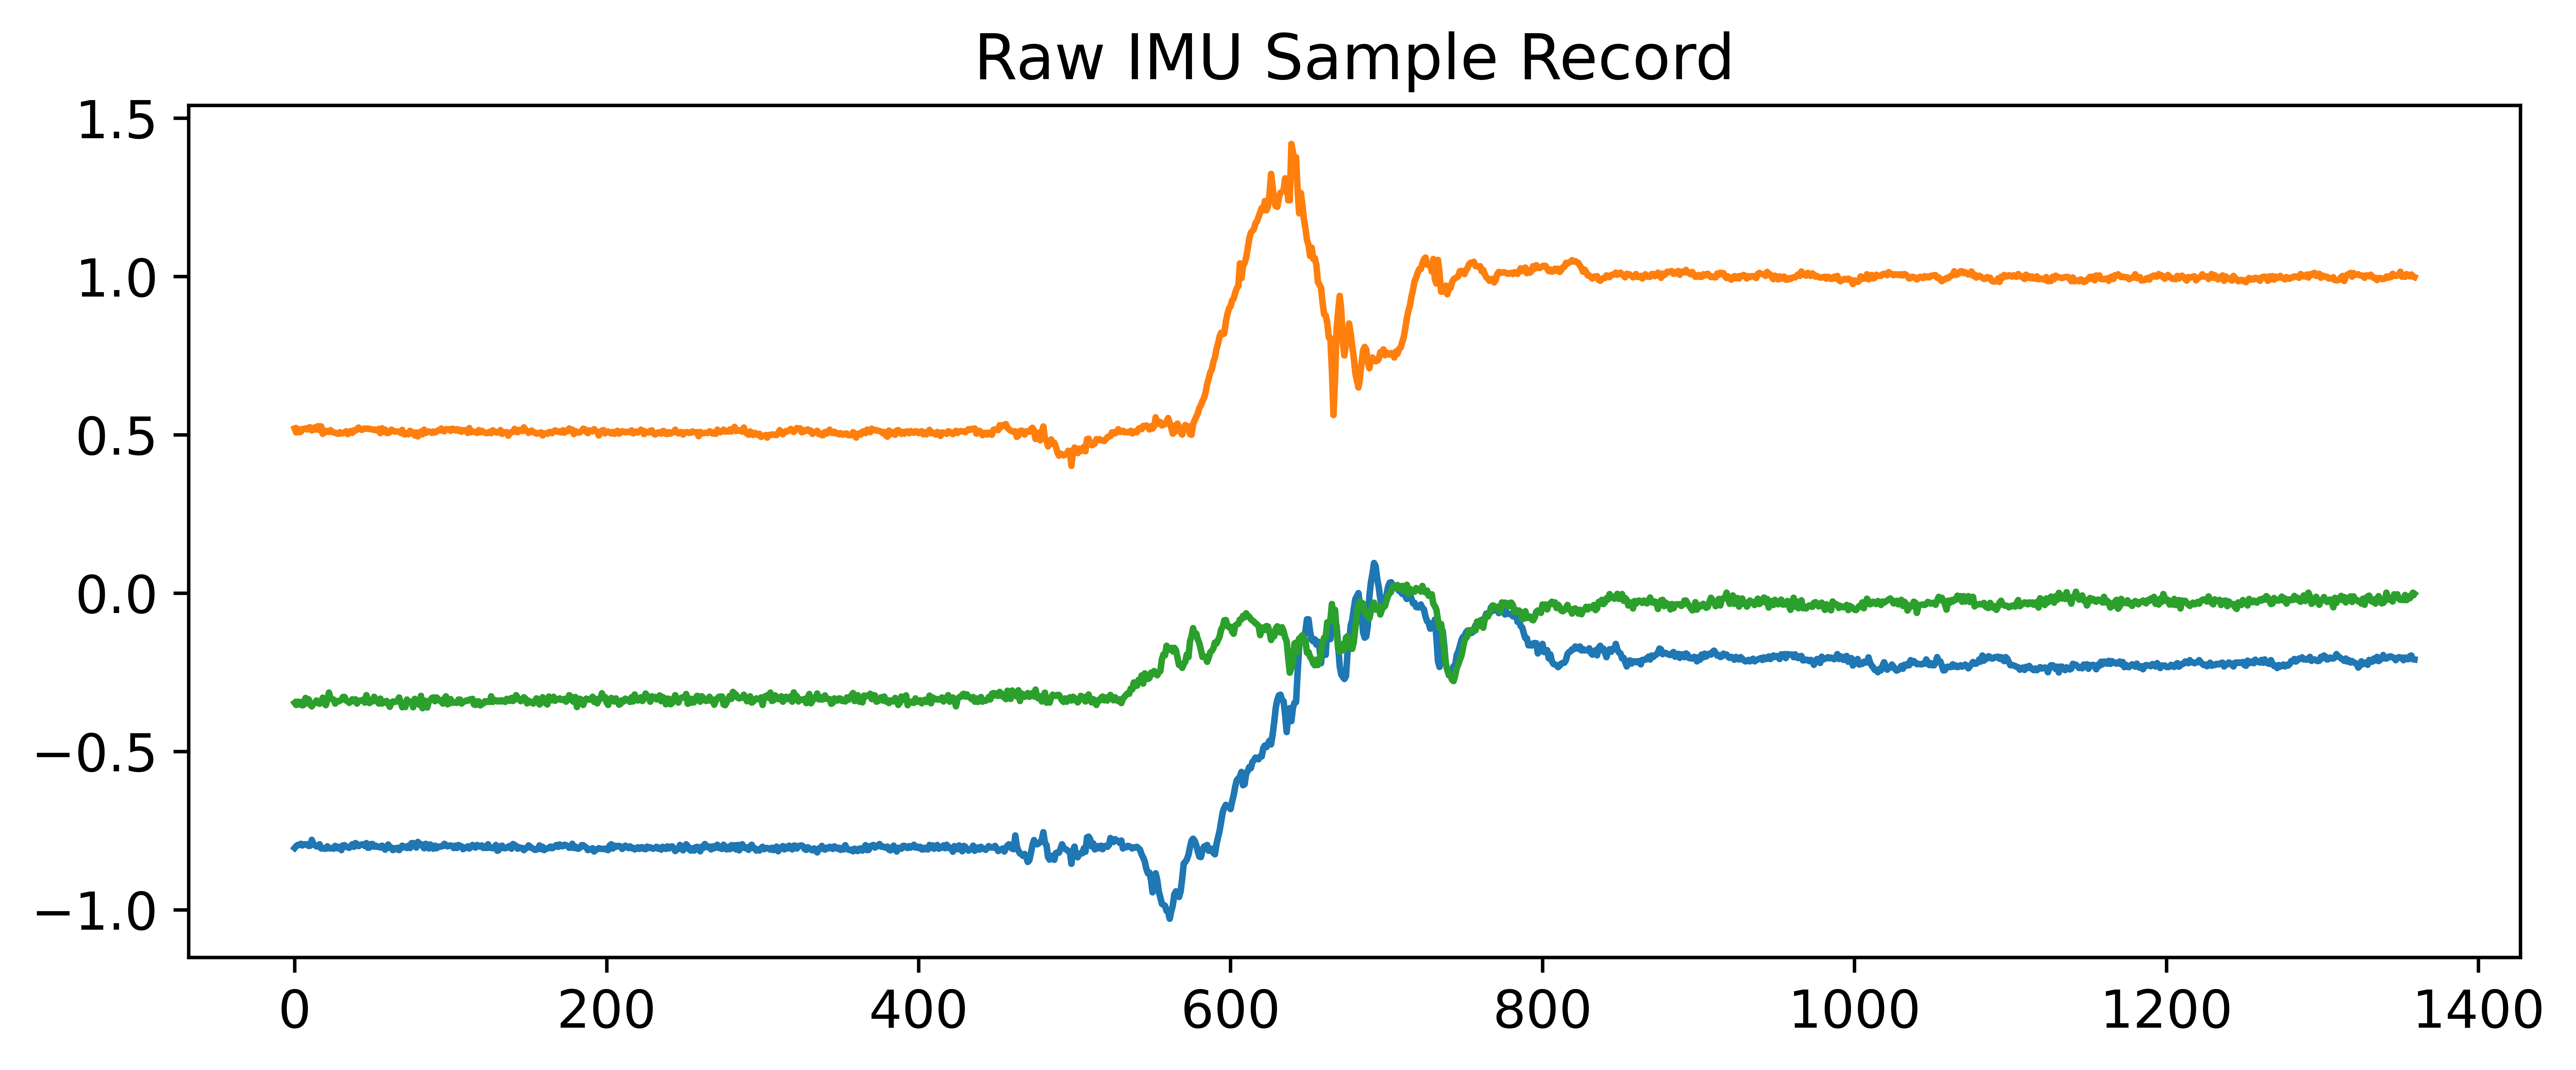

In [19]:
with open("data.npy", "rb") as f:
    data = np.load(f)

plt.figure()
plt.plot(data)
plt.title(f"Raw IMU Sample Record")
plt.show()


In [20]:
data.shape


(1360, 3)

## Step 1 : Quantize the data

Scale is obtained by investigating the dataset statistics. The maximum amplitude = 1.0 using scale factor=`0.49`

In [21]:
num_bits_in = 16
quantizer = Quantizer(shape=3, scale=0.49, num_bits=num_bits_in)


In [22]:
data_quantized, _, _ = quantizer(data)
data_quantized.shape


(1, 1360, 3)

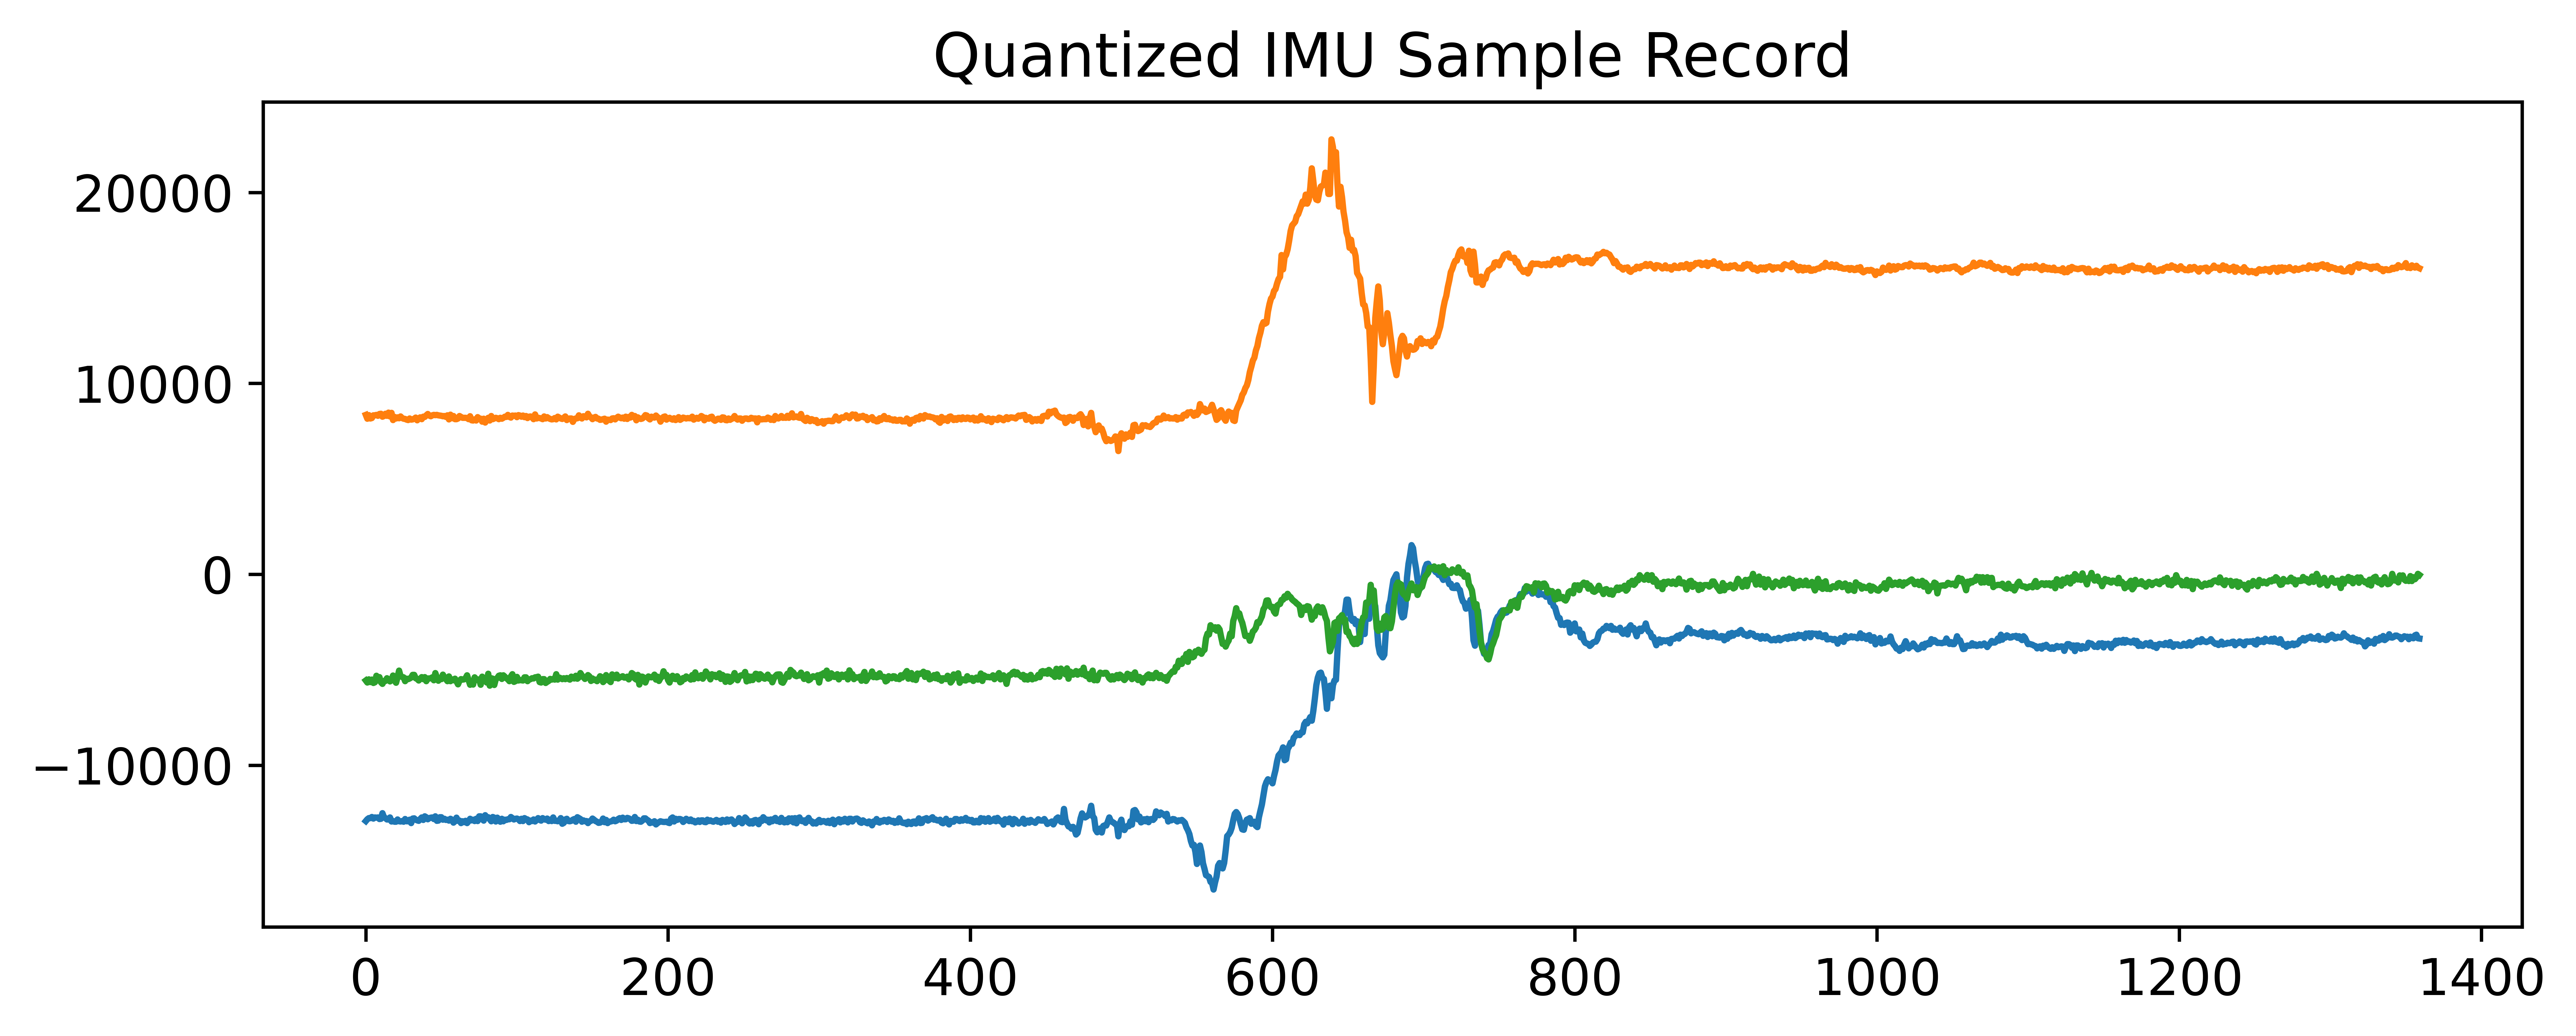

In [23]:
plt.figure()
plt.plot(data_quantized[0])
plt.title(f"Quantized IMU Sample Record")
plt.show()


## Step 2 : Rotation Removal

In [24]:
# --- create a suitable lookup table
num_angles = 64
num_bits = 16

# --- build a covariance estimation module
num_bits_multiplier = num_bits + 10
num_avg_bitshift = 4  # how fast the averaging is done
num_bits_highprec_filter = num_bits_multiplier + num_avg_bitshift

# create a sample-and-hold module
sampling_period = 10

# --- create a JSVD compuatation module
num_bits_covariance = 2 * num_bits_multiplier
num_bits_rotation = 2 * num_bits_multiplier
nround = 4


# create a rotation removal module
num_bits_out = num_bits
rot_removal = RotationRemoval(
    num_bits_in=num_bits,
    num_bits_out=num_bits_out,
    num_bits_multiplier=num_bits_multiplier,
    num_bits_highprec_filter=num_bits_highprec_filter,
    num_avg_bitshift=num_avg_bitshift,
    sampling_period=sampling_period,
    num_angles=num_angles,
    num_bits_lookup=num_bits,
    num_bits_covariance=num_bits_covariance,
    num_bits_rotation=num_bits_rotation,
    nround=nround,
)


In [25]:
data_normalized, _, _ = rot_removal(data_quantized)

# Sign correction
correction_factor = np.sign(data_normalized) * np.sign(data)
data_normalized = data_normalized * correction_factor
data_normalized = data_normalized.astype(np.int64).astype(object)
data_normalized.shape


(1, 1360, 3)

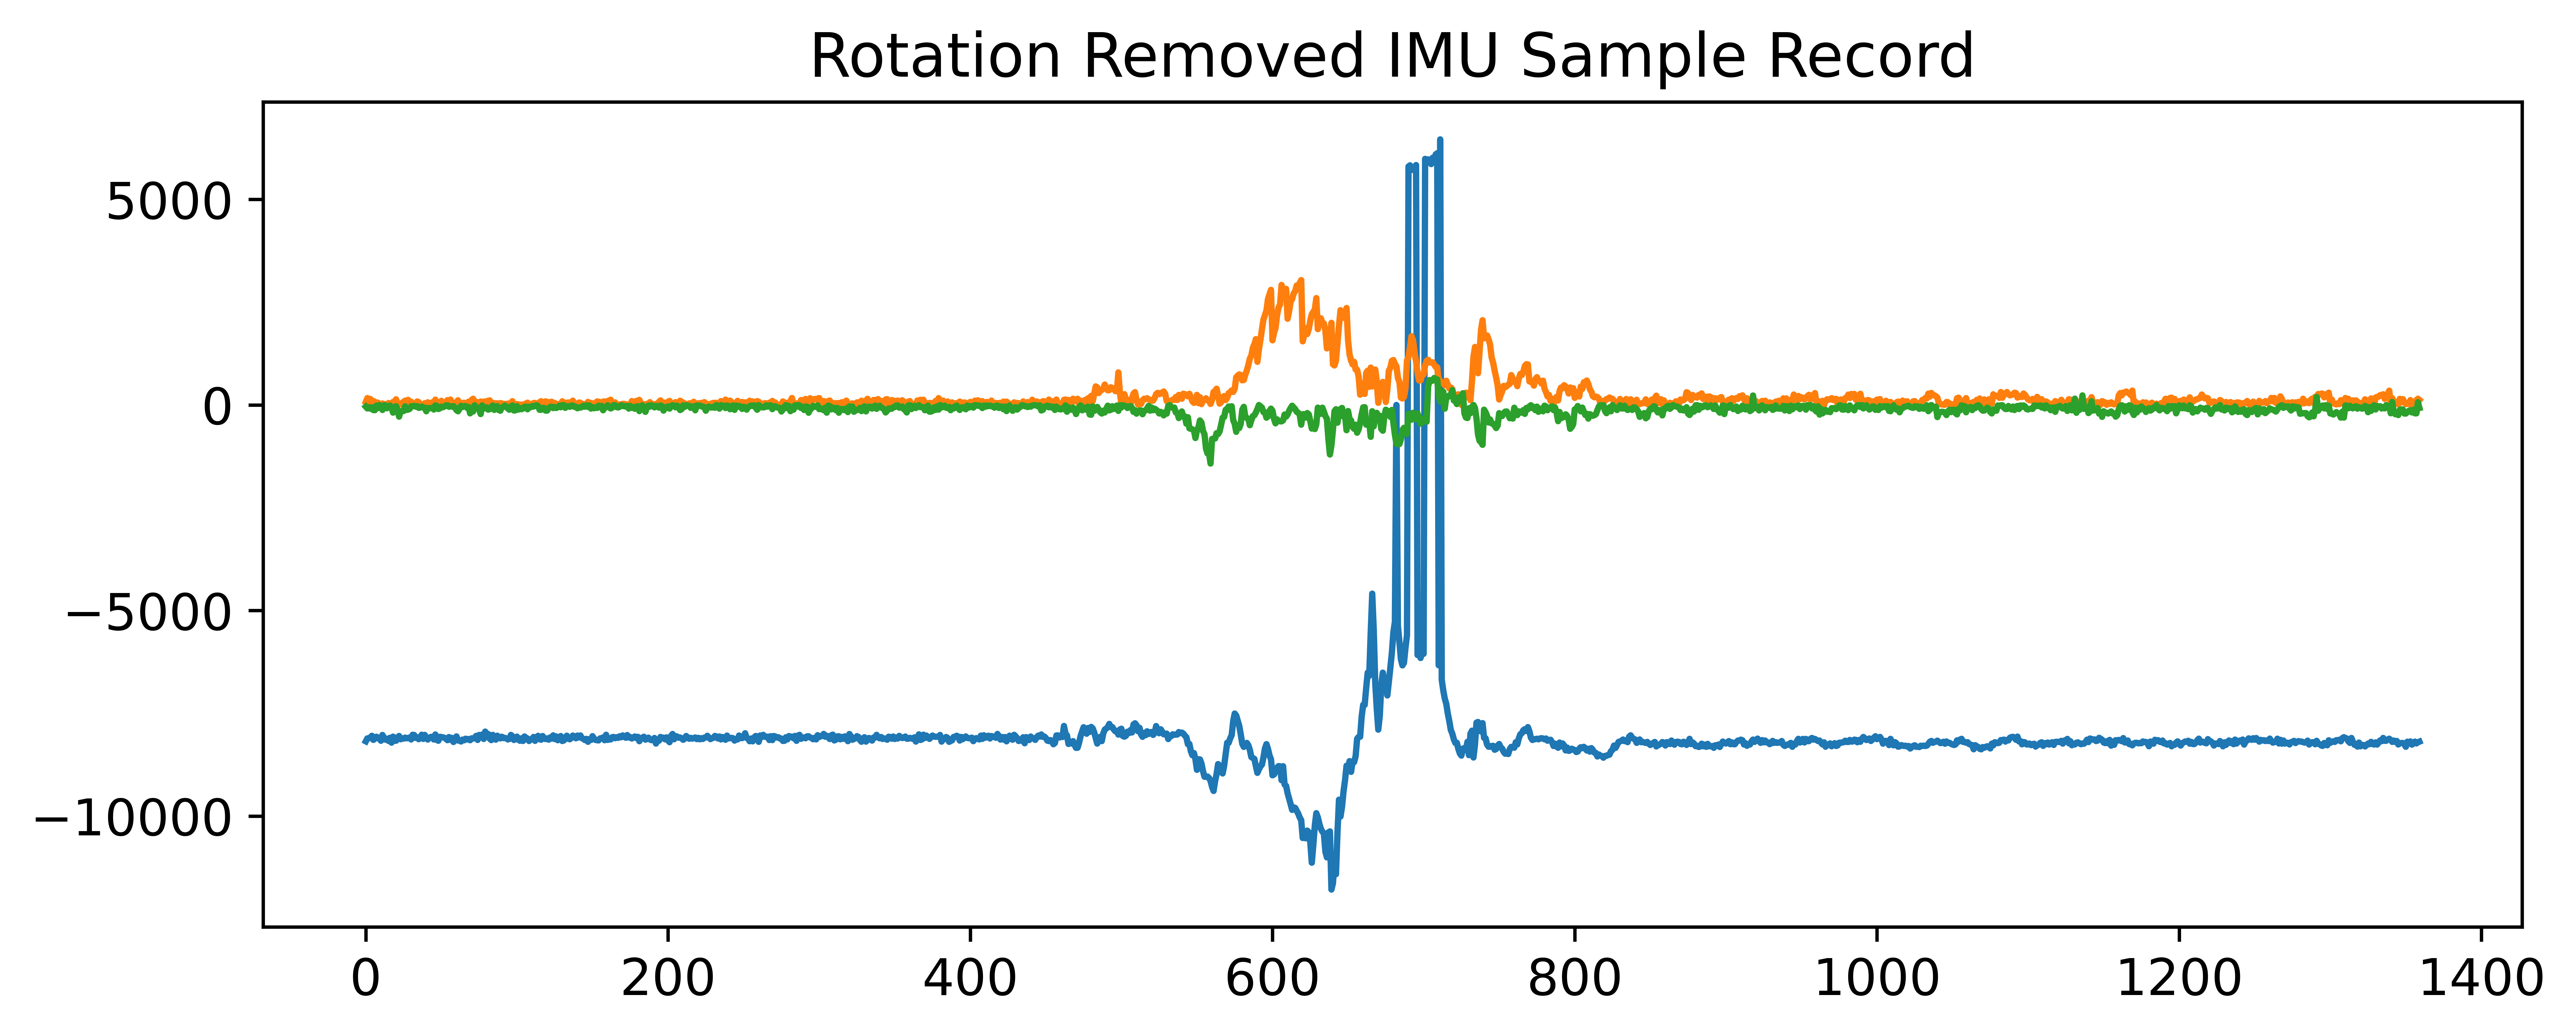

In [26]:
plt.figure()
plt.plot(data_normalized[0])
plt.title(f"Rotation Removed IMU Sample Record")
plt.show()


## Step 3 : Filtering

In [27]:
filterbank = FilterBank()


In [28]:
filtered, _, _ = filterbank(data_normalized)
filtered.shape


(1, 1360, 48)

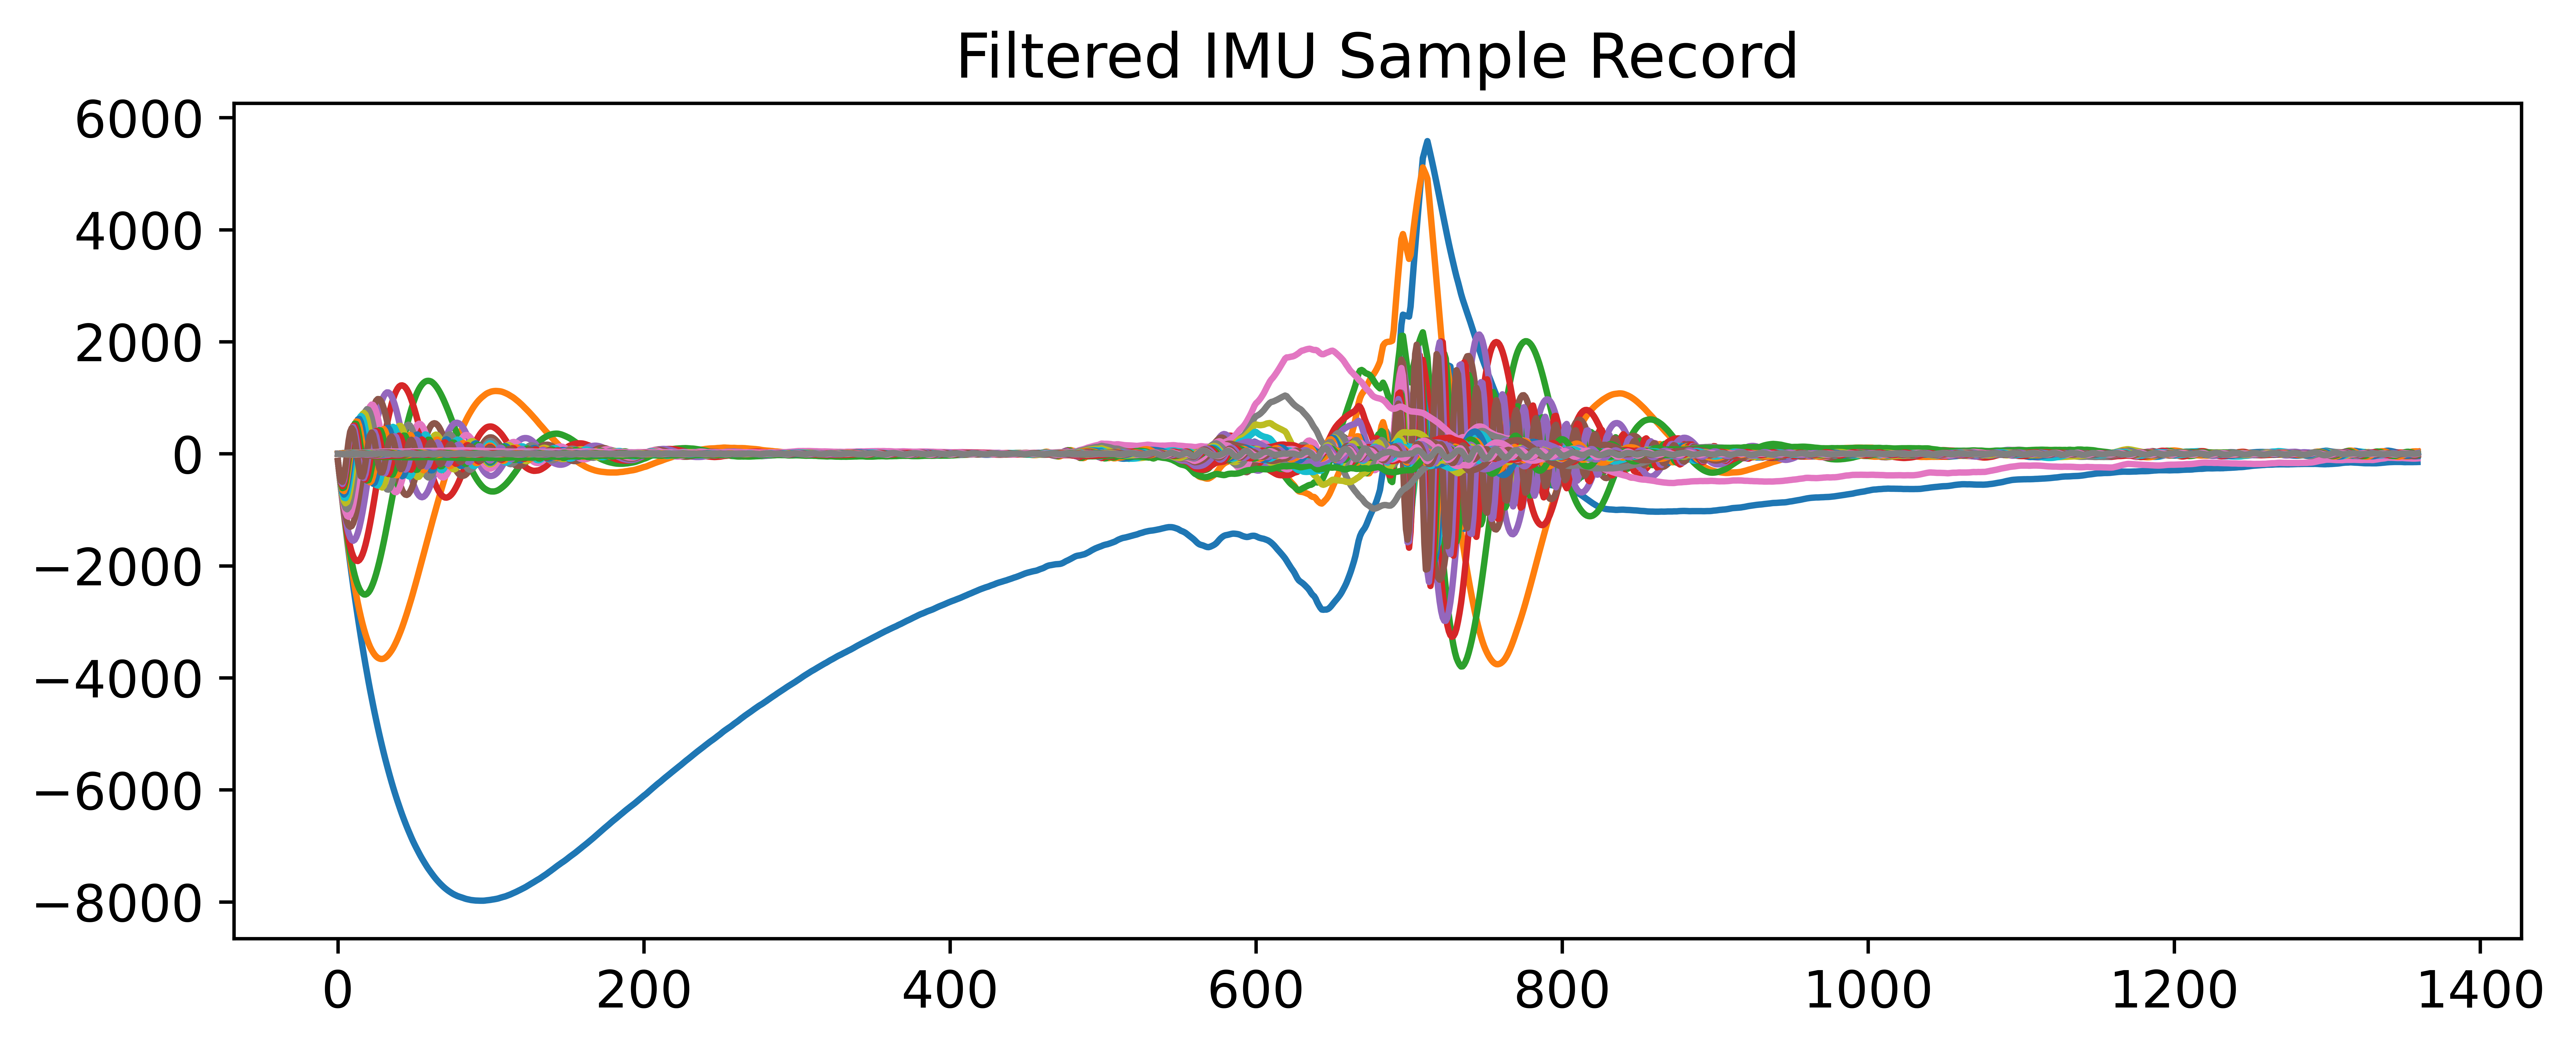

In [29]:
plt.figure()
plt.plot(filtered[0])
plt.title(f"Filtered IMU Sample Record")
plt.show()


## Step 4 : Rectification

In [30]:
rectifier = FullWaveRectifier()
rectified, _, _ = rectifier(filtered)
rectified.shape

(1, 1360, 48)

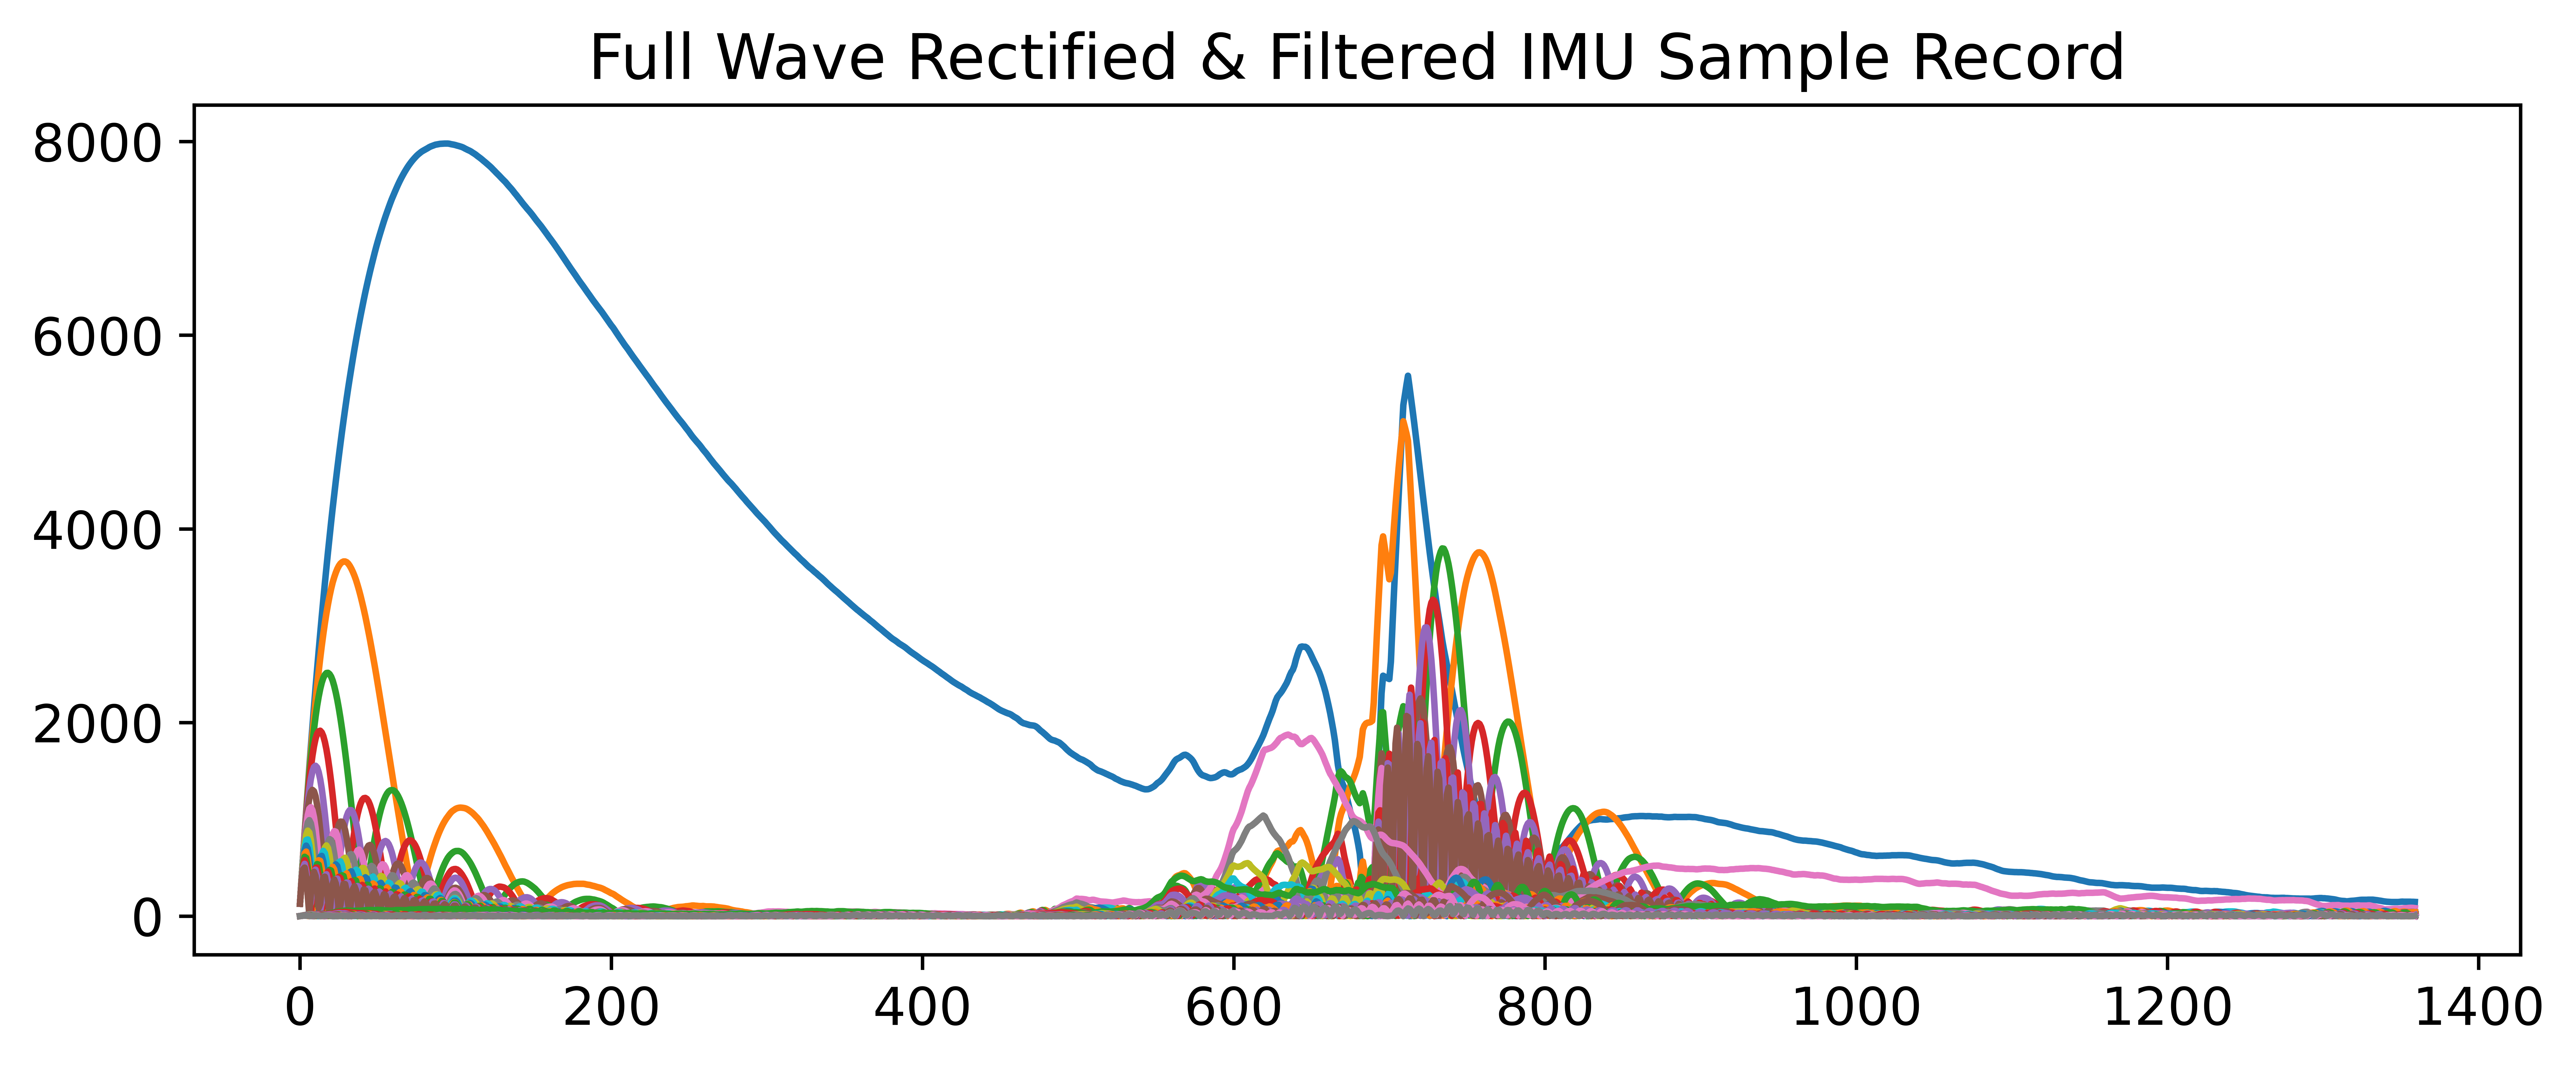

In [31]:
plt.figure()
plt.plot(rectified[0])
plt.title(f"Full Wave Rectified & Filtered IMU Sample Record")
plt.show()

## Final : Combine All

In [32]:
mod_IMUIF = Sequential(
    Quantizer(scale=0.49, num_bits=num_bits_in),
    RotationRemoval(
        num_bits_in=num_bits,
        num_bits_out=num_bits_out,
        num_bits_multiplier=num_bits_multiplier,
        num_bits_highprec_filter=num_bits_highprec_filter,
        num_avg_bitshift=num_avg_bitshift,
        sampling_period=sampling_period,
        num_angles=num_angles,
        num_bits_lookup=num_bits,
        num_bits_covariance=num_bits_covariance,
        num_bits_rotation=num_bits_rotation,
        nround=nround,
    ),
    FilterBank(),
    FullWaveRectifier(),
)


In [33]:
result, _, _ = mod_IMUIF(data)
result.shape


(1, 1360, 48)

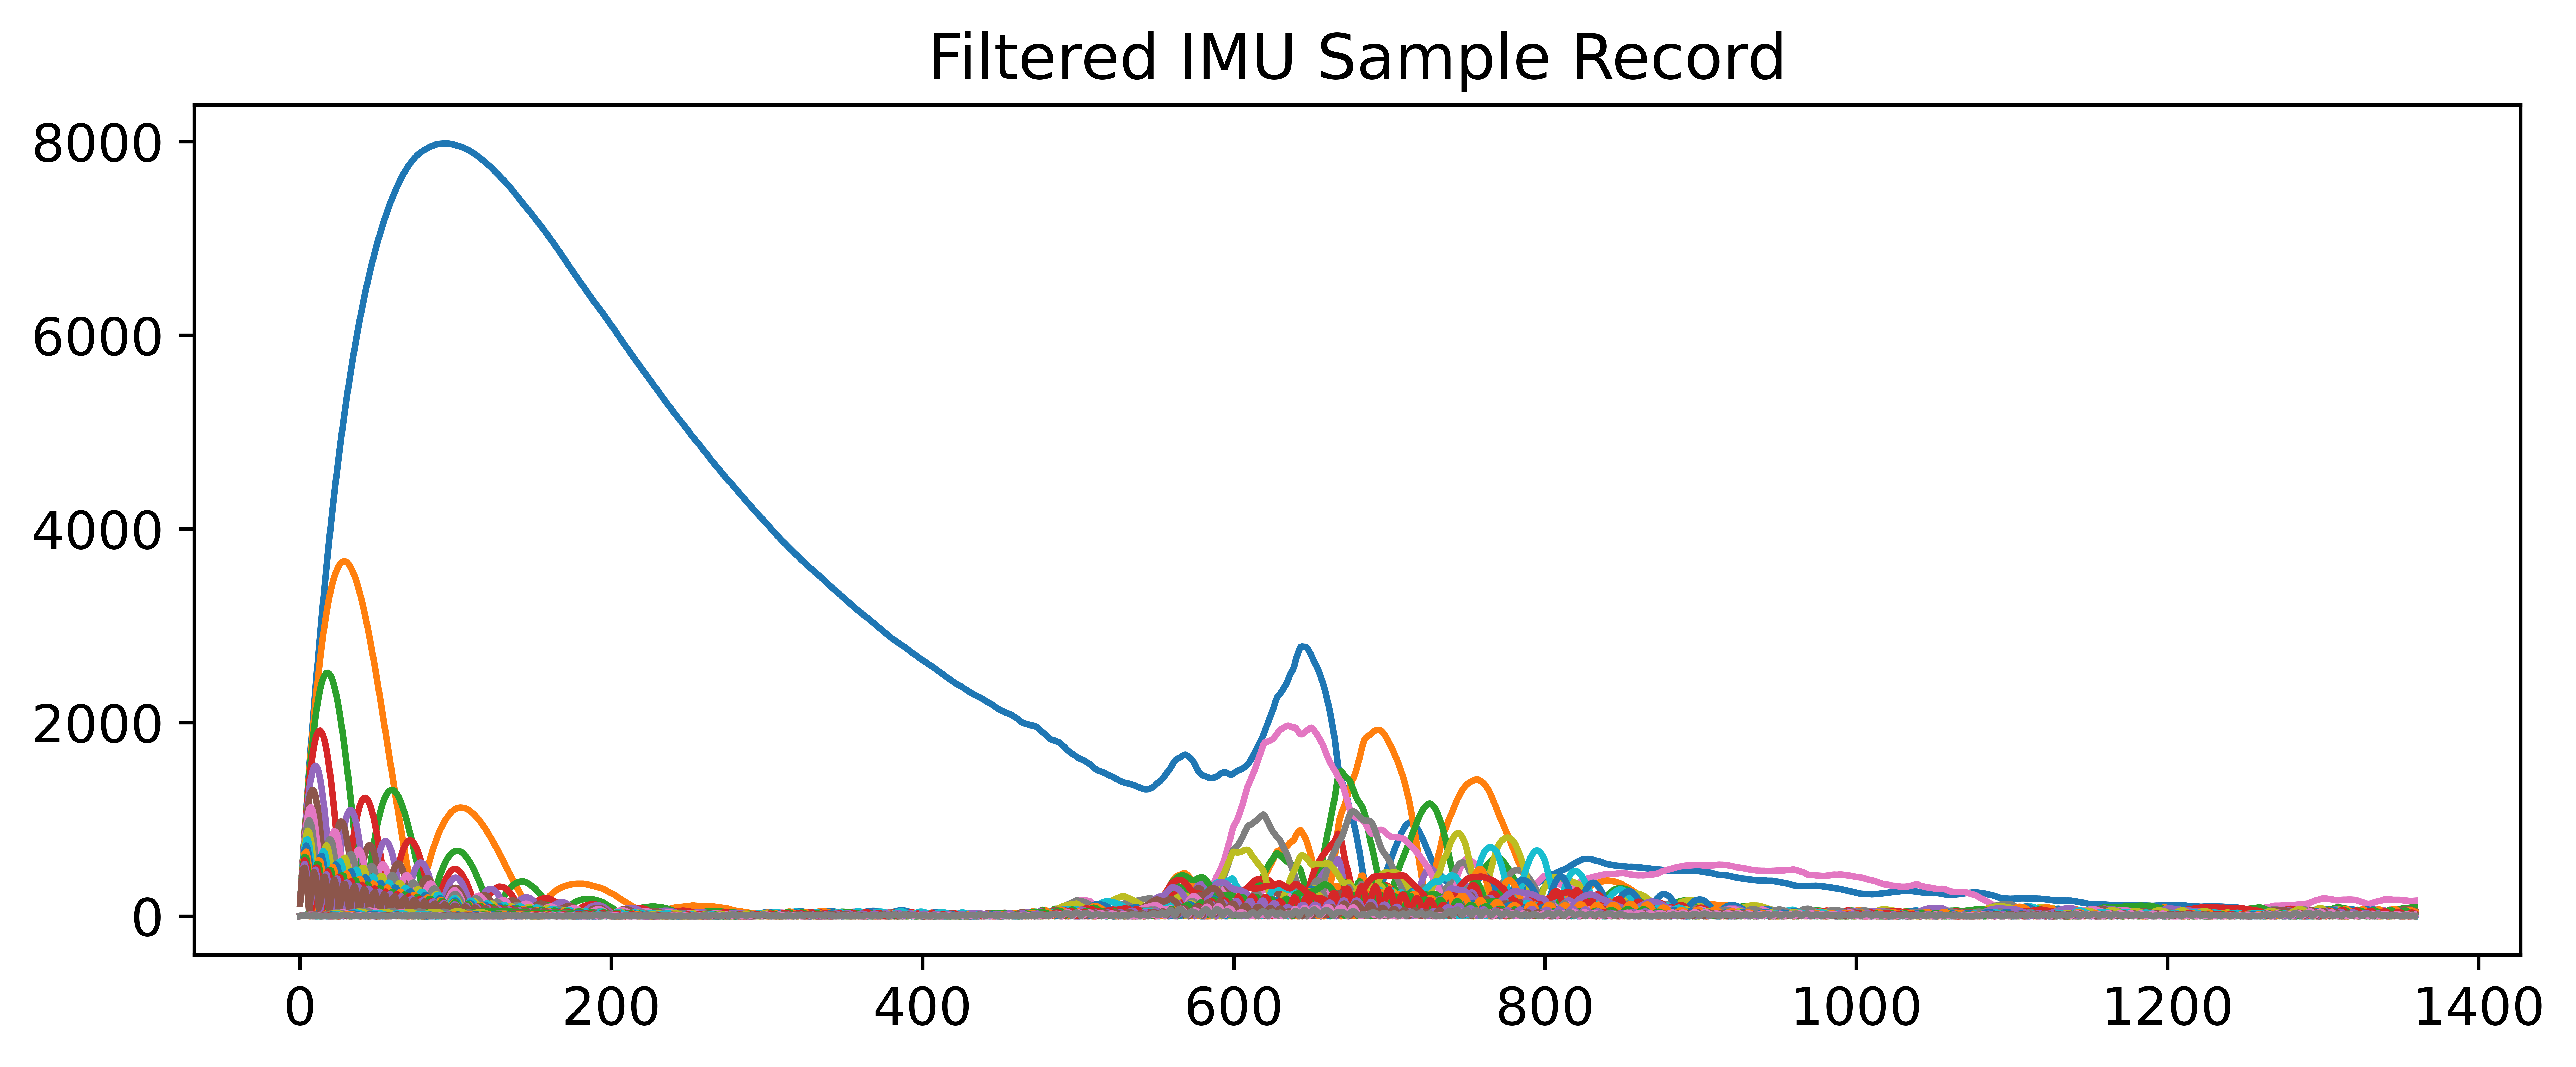

In [34]:
plt.figure()
plt.plot(result[0])
plt.title(f"Filtered IMU Sample Record")
plt.show()
